In [155]:
# code copy from dataprocess.py
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as  sns

100%|██████████| 2496/2496 [00:15<00:00, 159.39it/s]


'\nvec_frame:[id,[label_vec]]\n'

In [ ]:
def tree_to_table(tree):
    table= []
    for i in tree:
        a = i["value"]
        for j in i["children"]:
            b = j["value"]
            for z in j["children"]:
                c=z["value"]
                table.append([a,b,c])
    return table

def get_level3labels(tree):
    level3labels = []
    for t in tree:
        level1 = t['value']
        children1 = t['children']
        for child1 in children1:
            level2 = child1['value']
            children2 = child1['children']
            for child2 in children2:
                level3 = child2['value']
                level3labels.append('/'.join([level1, level2, level3]))
    return level3labels

def labeltree_dataset(textual_tree,code_tree,process_data_path):
    textual_table = []
    code_table = []


    textual_table = tree_to_table(textual_tree)
    code_table = tree_to_table(code_tree)
    textual_frame = pd.DataFrame(textual_table,columns=["A","B","C"])
    code_frame = pd.DataFrame(code_table,columns=["A","B","C"])

    text_code_frame = pd.concat([code_frame["C"],textual_frame["C"]],axis=1)
    text_code_frame.columns = ["code_label","textual_label"]

    code_dict = dict(zip(code_frame["C"],textual_frame["C"]))
    # print("code_dict size:",len(code_dict))
    # print("code_frame size",code_frame.shape[0])
    # print("text_frame size",textual_frame.shape[0])

    textual_frame.to_csv(process_data_path+'textual_frame.csv',index=False)
    code_frame.to_csv(process_data_path+'code_frame.csv',index=False)
    text_code_frame.to_csv(process_data_path+'text_code_frame.csv',index=False)

    return textual_frame,code_frame,text_code_frame

def print_list(l):
    for i in l: print(i)

def create_train_dataset(textual_frame,code_frame,data,process_data_path):
    columns = ['id','label','content']
    label_size=textual_frame.shape[0]
    process_data = []
    y=0
    label_set = set()
    label_c_set = set()
    for i in tqdm(data):
        content_list = []
        for j in i["content"]:
            content_list.append([i["id"],label_size,j])
    
        for j in i["evidence"]:
            idx = j["index"]
            value_list = j["value"]
            
            pro_value_list = []
            for z in value_list:
                label_set.add(z)
                code_label = z.split('/')[-1]
                label_c_set.add(code_label)
                num_label = code_frame[code_frame["C"]==code_label].index.values[0]
                pro_value_list.append(str(num_label))
                
            content_list[idx][1] = '#'.join(pro_value_list)
        

        if not process_data:
            process_data = content_list
        else:
            process_data=process_data+content_list
    # 234
    # print(len(label_set))
    # print(len(label_c_set))
    dataset = pd.DataFrame(process_data,columns=columns)
    dataset.to_csv(process_data_path+'train.csv',index = False)
    return dataset





process_data_path = '../preprocessdata/'
if not os.path.exists(process_data_path):
    os.mkdir(process_data_path)

code_tree=json.load(open('../rawdata/code_tree.json', encoding='utf-8'))
textual_tree = json.load(open('../rawdata/textual_tree.json', encoding='utf-8'))

code_list = get_level3labels(code_tree)
textual_list = get_level3labels(textual_tree)
# 216
# print(len(code_list))
# print(len(textual_list))
data=json.load(open('../rawdata/train.json', encoding='utf-8'))

'''
textual_frame: [A,B,C] 三级标签-中文
code_frame: [A,B,C] 三级标签-代码
text_code_frame: [C1,C2] 三级标签映射
共234条三级标签，加上负样本为235个标签
'''
textual_frame,code_frame,text_code_frame=labeltree_dataset(textual_tree,code_tree,process_data_path)
'''
train_frame:[id,label,text]
'''
train_data=create_train_dataset(textual_frame,code_frame,data,process_data_path)

In [ ]:
# basic data discribe
# print(train_data.shape)
print(train_data[train_data["content"]==""].shape)
print(train_data[train_data["label"]==234].shape)
print(train_data[train_data["label"]!=234].shape)
train_data["label_bool"] = 1
train_data["label_bool"].loc[train_data["label"]==234] =0

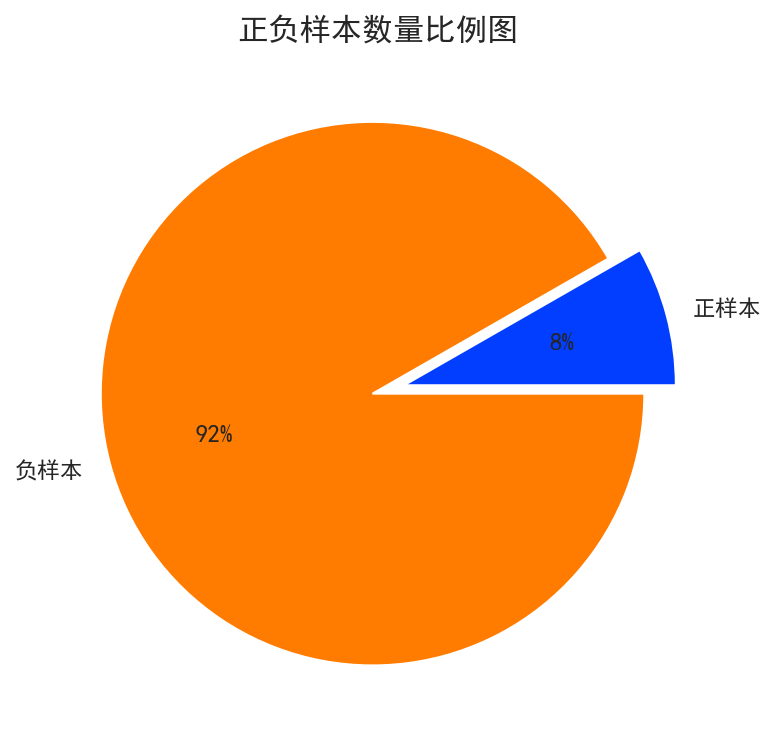

In [123]:

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

# 正负样本比例

plt.figure(figsize=(6,6),dpi=150)
pos_num=train_data[train_data["label"]!=234].shape[0]
neg_num = train_data[train_data["label"]==234].shape[0]
data_1 = [pos_num, neg_num]
explode = [0.1,0.02]
labels = ['正样本', '负样本']
colors = sns.color_palette('bright')
plt.pie(data_1, labels=labels,colors = colors, autopct = '%0.0f%%', explode = explode)
plt.title("正负样本数量比例图",fontsize = 15)
plt.savefig('./output/pie1.jpg')
plt.show()

count    2496.000000
mean        7.670272
std         4.092401
min         1.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        28.000000
dtype: float64


c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


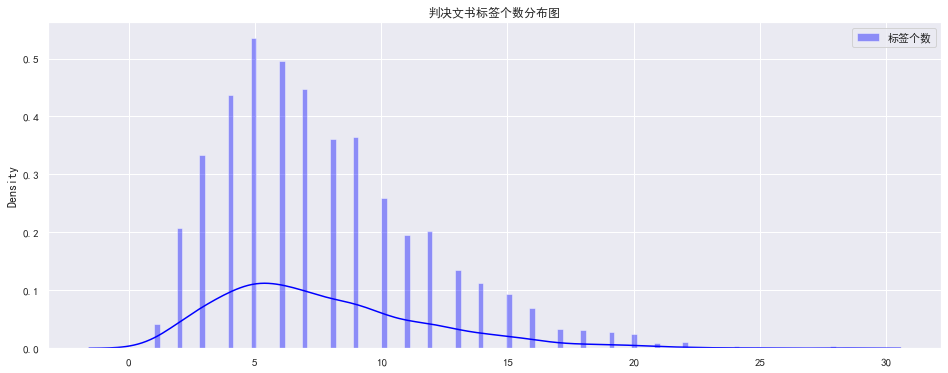

In [127]:
# 文书标签个数分布
def create_vectorlabel_dataset(data,process_data_path):
    vectorlabel_list = []    
    case_label_num = []
    label_num=np.zeros(234,'int64')
    for i in data:
        vectorlabel = np.zeros(235,'int64')
        vectorlabel[0]=int(i["id"])
        for j in i["result"]: 
            idx=int(j.split('/')[-1][1:])
            vectorlabel[idx+1] = 1
            label_num[idx]+=1
        case_label_num.append(len(i["result"]))    
        vectorlabel_list.append(vectorlabel)

    vec_frame = pd.DataFrame(np.array(vectorlabel_list))
    vec_frame.to_csv(process_data_path+'vec_frame.csv',index = False)
    return vec_frame,case_label_num,label_num
    
case_data,case_label_num,label_num=create_vectorlabel_dataset(data,process_data_path)
print(pd.Series(case_label_num).describe())
plt.figure(figsize=(16,6))
plt.title("判决文书标签个数分布图")
# sns.distplot(label_num.mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(case_label_num,color="blue", kde=True,bins=120, label='标签个数')
plt.legend()
plt.savefig('output/case_label_num.jpg')
plt.show()

count     234.000000
mean       81.816239
std       167.847636
min         0.000000
25%         4.000000
50%        13.500000
75%        82.000000
max      1589.000000
Name: number, dtype: float64


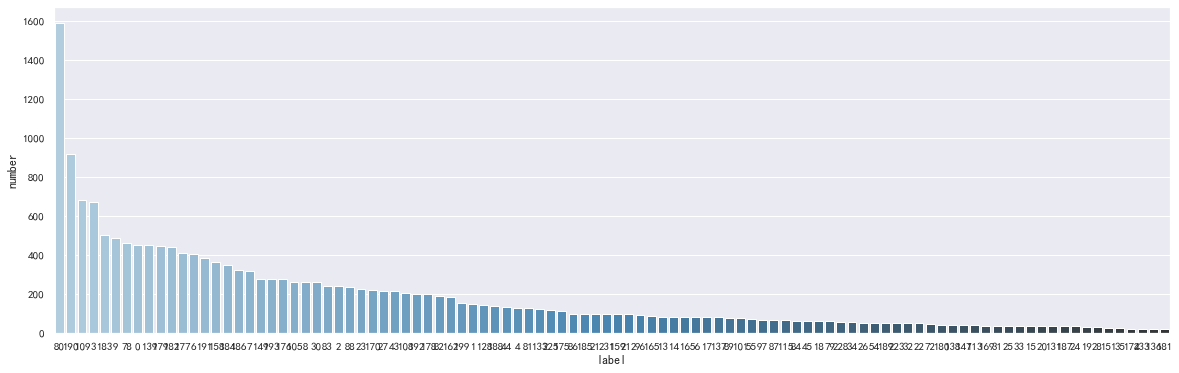

In [167]:
# 标签种类个数分布
# 构造数据
maxnum = 100
plt.figure(figsize=(20,6))
a = pd.DataFrame({"label": np.arange(234)})
b = pd.DataFrame({"number": label_num})
c = pd.DataFrame({"textual_label":textual_list})
df = pd.concat([a, b,c], axis=1)
print(df['number'].describe())
# 对特征按照重要性程度的从大到小进行排序
df = df.sort_values(by="number", ascending=False)
# 只输出前10个重要的特征
df = df[0:maxnum]
# 设置order参数：按重要程度（importance）从大到小输出的结果:
sns.barplot(x="label", y="number", 
					data=df, order=df["label"], orient="v",palette="Blues_d")
plt.savefig('output/label_num.jpg')

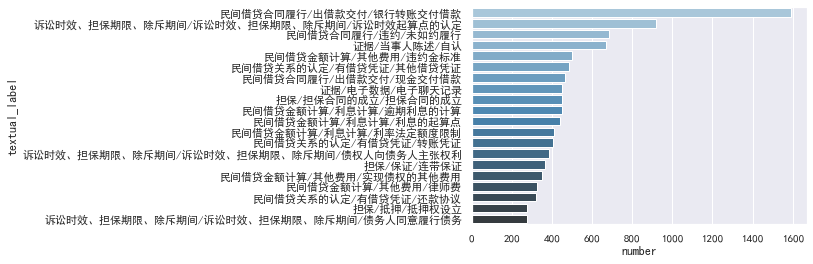

In [152]:
# 标签种类个数分布
maxnum = 20
df = df[0:maxnum]
sns.barplot(x="number", y="textual_label", 
					data=df, order=df["textual_label"], orient="h",palette="Blues_d")
plt.savefig('output/case_label_num_max.jpg')


count    284323.000000
mean         45.809337
std          40.359738
min           0.000000
25%          17.000000
50%          36.000000
75%          63.000000
max        1113.000000
Name: content_len, dtype: float64


c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


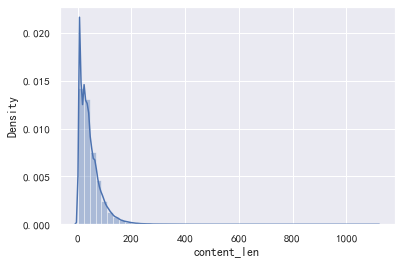

In [163]:
# 文本长度分布
train_data['content_len'] = train_data["content"].str.len()
print(train_data['content_len'].describe())
sns.distplot(train_data['content_len'])
plt.savefig('output/content_len.jpg')

c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


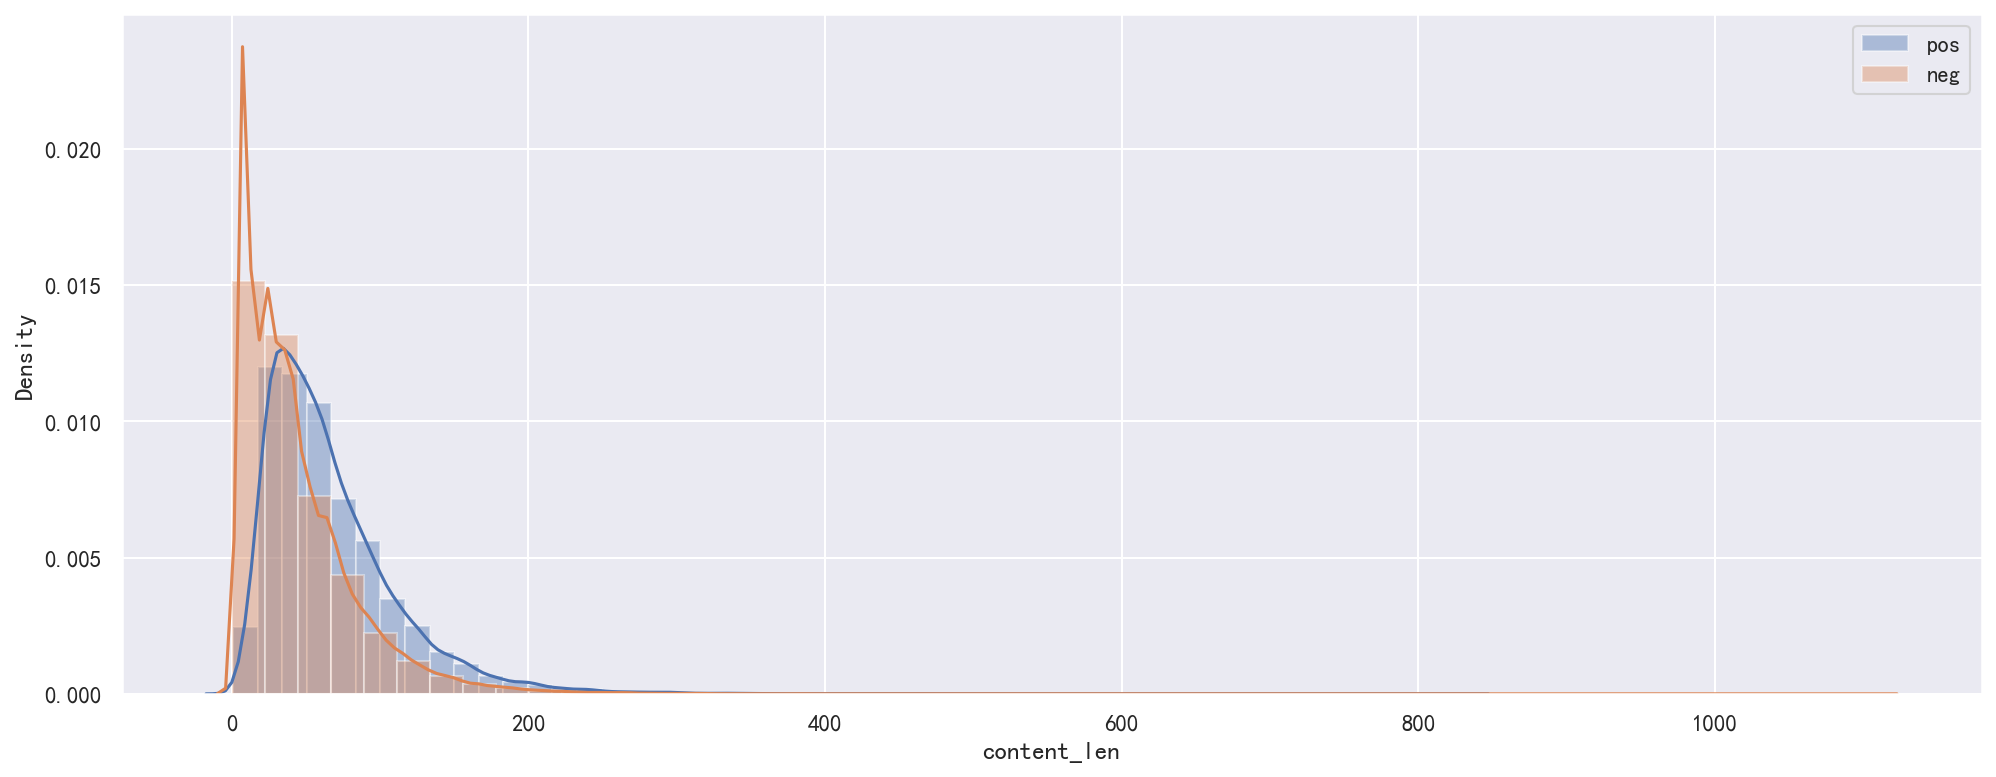

In [308]:
# 文本长度分布
pos_label = train_data[train_data["label"]!=234]['content_len']
neg_label = train_data[train_data["label"]==234]['content_len']
plt.figure(figsize=(16,6),dpi=150)
sns.distplot(pos_label,label = "pos")
sns.distplot(neg_label,label = "neg")
plt.legend()
plt.savefig('output/content_len_pn.jpg')
plt.show()


In [188]:
# 文本长度分布
print(pos_label.describe().index.values)
print(pos_label.describe().values)
print(neg_label.describe().values)
a = pos_label.describe().index.values
b = pos_label.describe().values
c = neg_label.describe().values
pd.DataFrame([a,b,c])

['count' 'mean' 'std' 'min' '25%' '50%' '75%' 'max']
[2.35430000e+04 6.72876014e+01 4.55413504e+01 1.00000000e+00
 3.50000000e+01 5.60000000e+01 8.70000000e+01 8.29000000e+02]
[2.60780000e+05 4.38702968e+01 3.92851782e+01 0.00000000e+00
 1.50000000e+01 3.40000000e+01 6.00000000e+01 1.11300000e+03]


,0,1,2,3,4,5,6,7
0,count,mean,std,min,25%,50%,75%,max
1,23543.0,67.287601,45.54135,1.0,35.0,56.0,87.0,829.0
2,260780.0,43.870297,39.285178,0.0,15.0,34.0,60.0,1113.0


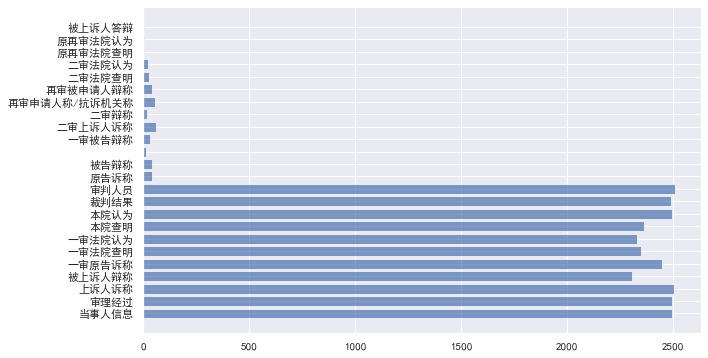

['当事人信息', '审理经过', '上诉人诉称', '被上诉人辩称', '一审原告诉称', '一审法院查明', '一审法院认为', '本院查明', '本院认为', '裁判结果', '审判人员', '原告诉称', '被告辩称', '', '一审被告辩称', '二审上诉人诉称', '二审辩称', '再审申请人称/抗诉机关称', '再审被申请人辩称', '二审法院查明', '二审法院认为', '原再审法院查明', '原再审法院认为', '被上诉人答辩']


In [292]:
# 片段出现频次
train_data.head(1000)
section_label = {}
flag = False
for i in train_data["content"]:
    if i != "" and i[0] == '【':
        key = i[1:-1]
        section_label[key] = section_label.get(key,0) + 1
        if key == '':
            flag=True
        else:
            flag = False
    if flag :
        # print(i)
        continue
 

#生成信息
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'r', 'b']
labels = list(section_label.keys())
data=list(section_label.values())
#生成柱状图
fig, ax = plt.subplots(figsize=(10,6))
bars1 = plt.barh(labels, data, align='center', alpha=0.7, tick_label=labels)

plt.savefig('output/section_label.jpg')
#展示结果
plt.show()
print(labels)

labels.append('开始')

In [271]:
columns = ['section_name','pos_num','neg_num','num','pos_rate','pos_size','neg_size','size','pos_size_rate']
section_frame = pd.DataFrame(np.zeros([len(labels),len(columns)]),columns=columns)
section_frame.section_name = labels
section_dict = dict(zip(labels,range(len(labels))))


In [272]:
#片段正样本比例
key = '开始'
section_frame.set_index('section_name')
for j,case_data in tqdm(train_data.groupby('id')):
    for i,row in case_data.iterrows():
        if row['content'] != "" and row["content"][0] =='【':
            key = row['content'][1:-1]
            continue
        section_frame.loc[section_dict[key],'num'] += 1 
        section_frame.loc[section_dict[key],'size'] +=len(row['content'])
        if row['label'] != 234:
            section_frame.loc[section_dict[key],'pos_num'] += 1      
            section_frame.loc[section_dict[key],'pos_size'] +=len(row['content'])   
        else:
            section_frame.loc[section_dict[key],'neg_num'] +=1
            section_frame.loc[section_dict[key],'neg_size'] +=len(row['content'])
    key = '开始'
section_frame['pos_rate'] = section_frame['pos_num']/section_frame['num']
section_frame['pos_size_rate'] = section_frame['pos_size']/section_frame['size']


100%|██████████| 2496/2496 [04:16<00:00,  9.74it/s]


,section_name,pos_num,neg_num,num,pos_rate,pos_size,neg_size,size,pos_size_rate
0,当事人信息,0.0,14689.0,14689.0,0.000000,0.0,475539.0,475539.0,0.000000
18,再审被申请人辩称,0.0,340.0,340.0,0.000000,0.0,16484.0,16484.0,0.000000
13,,0.0,15.0,15.0,0.000000,0.0,153.0,153.0,0.000000
23,被上诉人答辩,0.0,9.0,9.0,0.000000,0.0,394.0,394.0,0.000000
10,审判人员,0.0,13484.0,13484.0,0.000000,0.0,115661.0,115661.0,0.000000
9,裁判结果,0.0,10182.0,10182.0,0.000000,0.0,292342.0,292342.0,0.000000
24,开始,0.0,7488.0,7488.0,0.000000,0.0,126776.0,126776.0,0.000000
3,被上诉人辩称,2.0,9854.0,9856.0,0.000203,175.0,433540.0,433715.0,0.000403
2,上诉人诉称,16.0,23899.0,23915.0,0.000669,916.0,1248338.0,1249254.0,0.000733
1,审理经过,7.0,8345.0,8352.0,0.000838,474.0,359357.0,359831.0,0.001317


In [305]:
section_frame=section_frame.sort_values(by=['pos_rate'],na_position='first')

c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


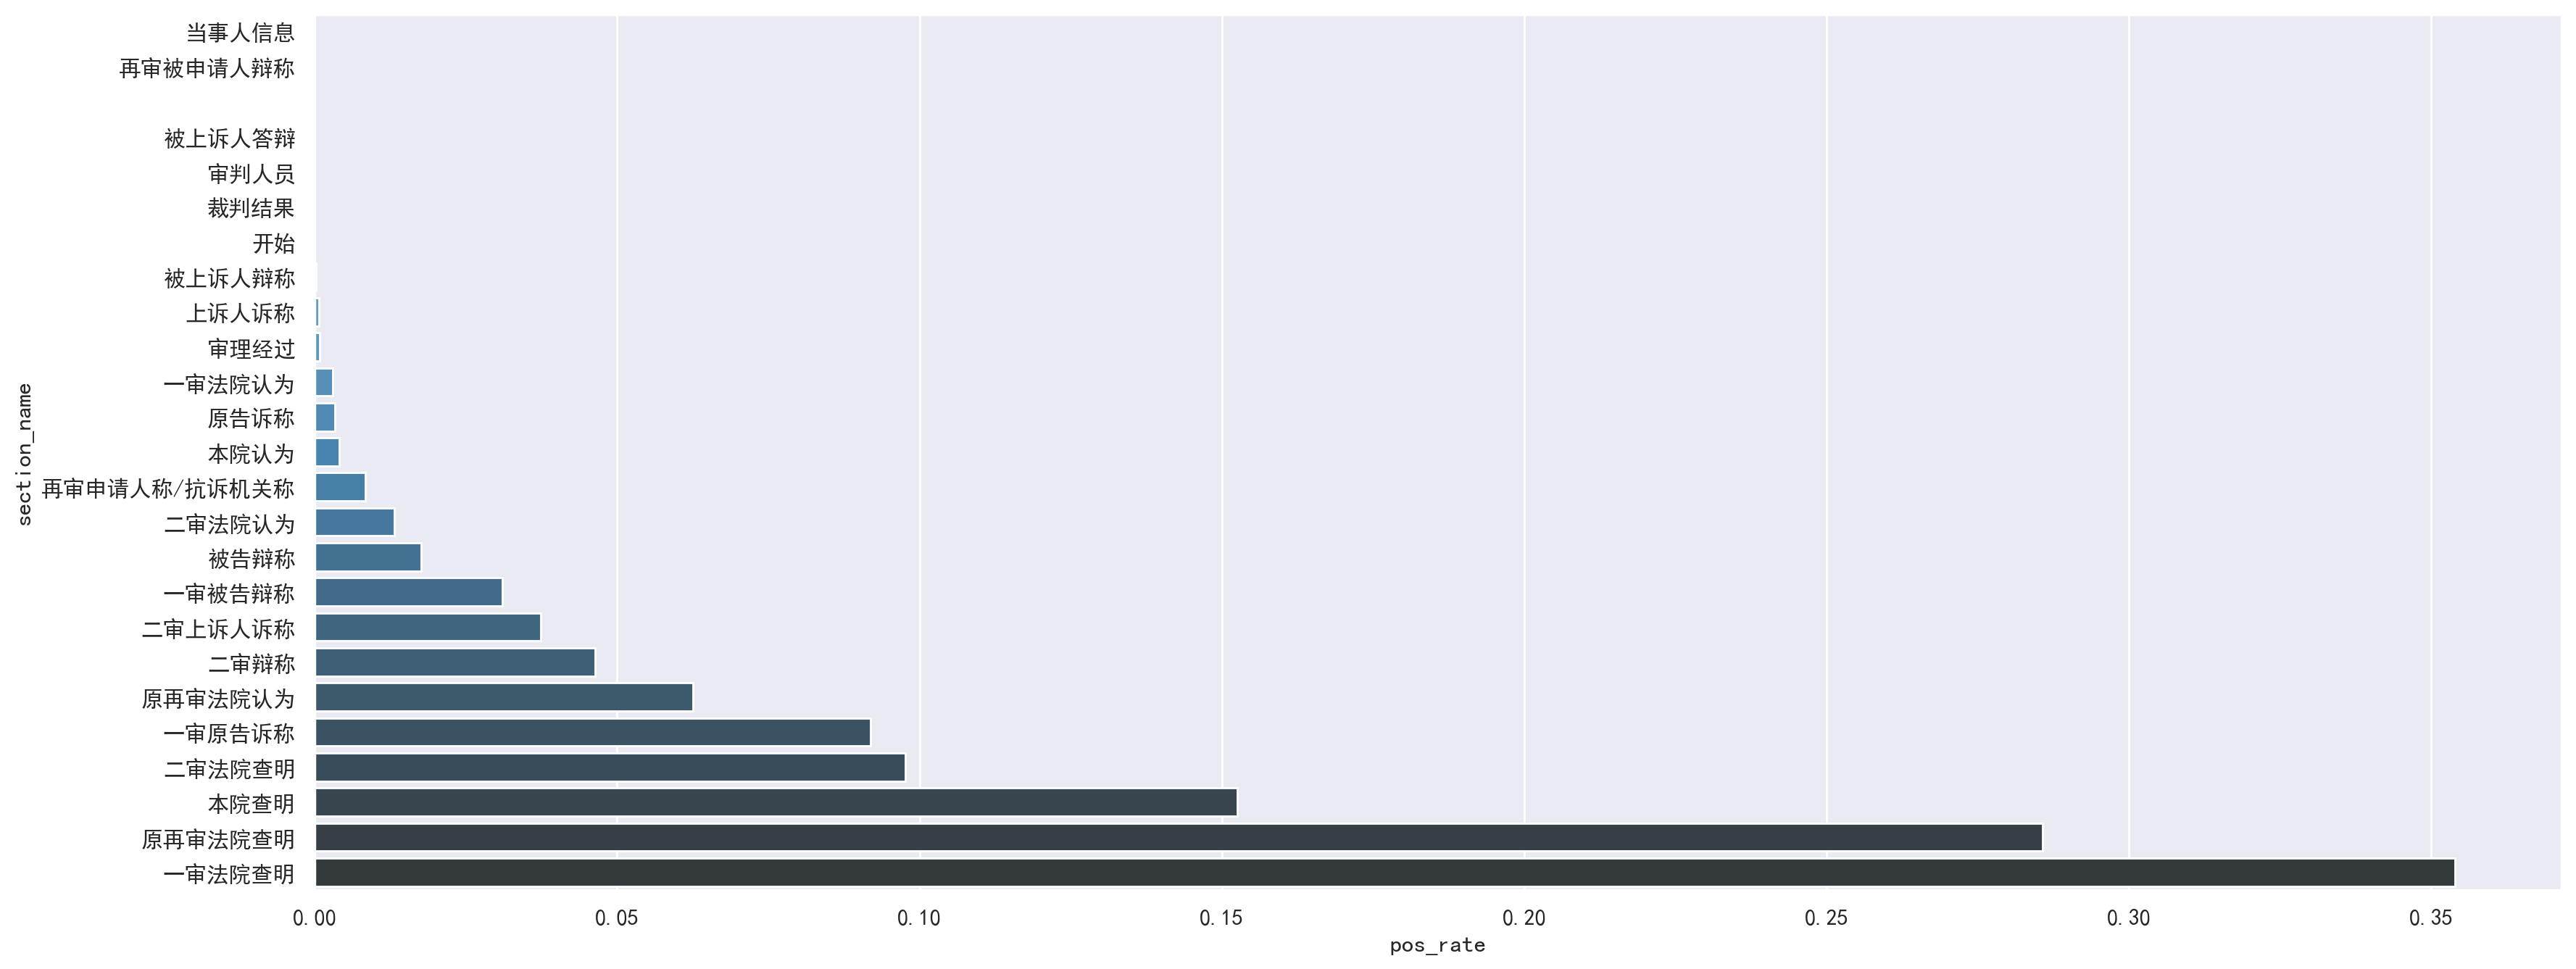

In [307]:

plt.figure(figsize=(20,8),dpi=200)
sns.barplot( section_frame["pos_rate"],section_frame["section_name"],orient="h",palette="Blues_d")	
plt.savefig('output/pos_rate.jpg')